In [1]:
from pathlib import Path
import os
import sys

main_directory = Path(os.path.abspath("")).parent
sys.path.append(str(main_directory))

## Create a quadratic model in docplex

In [2]:
from docplex.mp.model import Model

# set up the model for optimization in docplex
optimization_problem = Model()

# add the needed variables
x = optimization_problem.integer_var(0, 15, "x")
y = optimization_problem.integer_var(0, 15, "y")
a = optimization_problem.binary_var("a")
b = optimization_problem.binary_var("b")

# formally describe the minimization task
optimization_problem.minimize((2*x-y)**2 + 100*a*x - 100*b*y + (a + b - 1)**2)

## Convert the docplex model to a qiskit hamiltonian

In [3]:
from qiskit_optimization.translators import from_docplex_mp, to_ising
from qiskit_optimization.converters import IntegerToBinary

# convert to a quadratic program
quadratic_program = from_docplex_mp(model=optimization_problem)

# some variables are still integers, convert them to binary variables
integer_converter = IntegerToBinary()
quadratic_program = integer_converter.convert(problem=quadratic_program)

# convert the quadratic program to an ising hamiltonian
hamiltonian, offset = to_ising(quad_prog=quadratic_program)

## Setup the configuration for the EVQEMinimumEigensolver

In [4]:
from qiskit_aer.primitives import Sampler, Estimator
from qiskit_algorithms.optimizers import SPSA

from queasars.minimum_eigensolvers.evqe.evqe import EVQEMinimumEigensolverConfiguration

# The EVQEMinimumEigensolver needs a sampler and can also use an estimator.
# Here we use the sampler and estimator provided by the qiskit_aer simulator.
# We set a seed for reproducibility.
sampler_primitive = Sampler()
sampler_primitive.set_options(seed=0)
estimator_primitive = Estimator()
estimator_primitive.set_options(seed=0)

# The EVQEMinimumEigensolver also needs a qiskit optimizer. It should be
# configured to terminate quickly, so that mutations are not overtly expensive.
# Here we use the SPSA optimizer with a very limited amount of iterations and a
# large step size.
optimizer = SPSA(maxiter=10, perturbation=0.2, learning_rate=0.2, trust_region=True)

# To help the EVQEMinimumEigensolver deal correctly with terminations based
# on the amount of circuit evaluations used, an estimate can be given for how
# many circuit evaluations the optimizer uses per optimization run.
# SPSA makes two measurements per iteration, which means in total it will
# need 20 circuit evaluations for 10 iterations.
optimizer_n_circuit_evaluations = 20

# A dask client can be specified. If none is given, the EVQEMinimumEigensolver sets
# up a LocalCluster itself.
dask_client = None

# To specify when the EVQEMinimumEigensolver should terminate either max_generations,
# max_circuit_evaluations or a termination_criterion should be given.
# Here we choose to let the solver run for 10 evolutionary generations.
max_generations = 10
max_circuit_evaluations = None
termination_criterion = None

# A random seed can be provided to control the randomness of the evolutionary process.
random_seed = 0

# The population size determines how many individuals are evaluated each generation.
# With a higher population size, fewer generations might be needed, but this also
# makes each generation more expensive to evaluate. A reasonable range might be
# 10 - 100 individuals per population. Here we use a population size of 25.
population_size = 25

# If the optimization algorithm can't deal with parameter values of 0 at the beginning
# of the optimization, they can be randomized here. For this example we don't need this.
randomize_initial_population_parameters = True

# Determines how many circuit layers apart to individuals need to be to be considered to
# be of a different species. Reasonable values might be in the range 2 - 5. Here we use 3.
speciation_genetic_distance_threshold = 3

# The alpha and beta penalties penalize quantum circuits of increasing depth (alpha) and
# increasing amount of controlled rotations (beta). increase them if the quantum circuits get to
# deep or complicated. For now we will use values of 0.1 for both penalties.
selection_alpha_penalty = 0.1
selection_beta_penalty = 0.1

# The parameter search probability determines how likely an individual is mutated by optimizing
# all it's parameter values. This should not be too large as this is costly. Here we will use
# a probability of 0.25.
parameter_search_probability = 0.25

# The topological search probability determines how likely a circuit layer is added to an individual
# as a mutation. This should be a higher probability to encourage exploration of different circuits.
# Here we will use a likelihood of 0.5
topological_search_probability = 0.5

# The layer removal probability determines how likely circuit layers are removed from an individual
# as a mutation. This is a very disruptive mutation and should only be used sparingly to counteract
# circuit growth. Here we will use a probability of 0.1
layer_removal_probability = 0.1

configuration = EVQEMinimumEigensolverConfiguration(
    sampler=sampler_primitive,
    estimator=estimator_primitive,
    optimizer=optimizer,
    optimizer_n_circuit_evaluations=optimizer_n_circuit_evaluations,
    dask_client=dask_client,
    max_generations=max_generations,
    max_circuit_evaluations=max_circuit_evaluations,
    termination_criterion=termination_criterion,
    random_seed=random_seed,
    population_size=population_size,
    randomize_initial_population_parameters=randomize_initial_population_parameters,
    speciation_genetic_distance_threshold=speciation_genetic_distance_threshold,
    selection_alpha_penalty=selection_alpha_penalty,
    selection_beta_penalty=selection_beta_penalty,
    parameter_search_probability=parameter_search_probability,
    topological_search_probability=topological_search_probability,
    layer_removal_probability=layer_removal_probability,
)

## Setup the EVQEMinimumEigensolver

In [5]:
from queasars.minimum_eigensolvers.evqe.evqe import EVQEMinimumEigensolver

eigensolver = EVQEMinimumEigensolver(configuration=configuration)

## Solve the problem as posed in the hamiltonian

In [7]:
import logging

logging.basicConfig(level=logging.INFO)

result = eigensolver.compute_minimum_eigenvalue(operator=hamiltonian)
quasi_distribution = result.eigenstate.binary_probabilities()


INFO:queasars.minimum_eigensolvers.base.evolving_ansatz_minimum_eigensolver:Starting generation: 0
INFO:queasars.minimum_eigensolvers.base.evolving_ansatz_minimum_eigensolver:Expectation value of best individual found so far: -998
INFO:queasars.minimum_eigensolvers.base.evolving_ansatz_minimum_eigensolver:Starting generation: 1
INFO:queasars.minimum_eigensolvers.base.evolving_ansatz_minimum_eigensolver:Expectation value of best individual found so far: -1174
INFO:queasars.minimum_eigensolvers.base.evolving_ansatz_minimum_eigensolver:Starting generation: 2
INFO:queasars.minimum_eigensolvers.base.evolving_ansatz_minimum_eigensolver:Expectation value of best individual found so far: -1245
INFO:queasars.minimum_eigensolvers.base.evolving_ansatz_minimum_eigensolver:Starting generation: 3
INFO:queasars.minimum_eigensolvers.base.evolving_ansatz_minimum_eigensolver:Expectation value of best individual found so far: -1306
INFO:queasars.minimum_eigensolvers.base.evolving_ansatz_minimum_eigensolv

## Plot the distribution

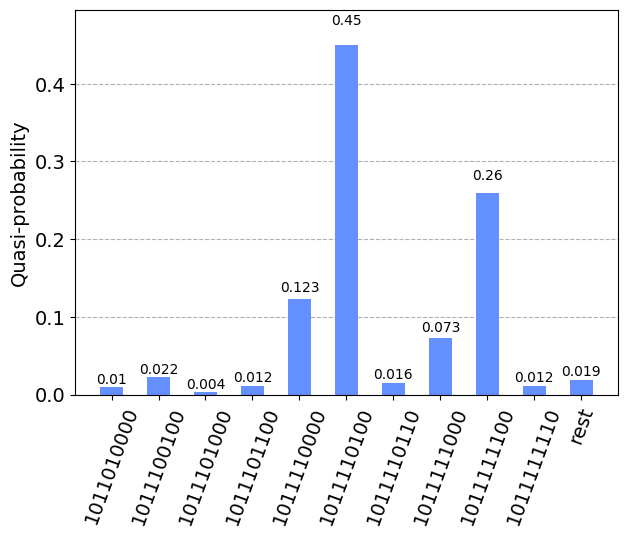

In [8]:
from qiskit.visualization import plot_distribution

plot_distribution(quasi_distribution, number_to_keep=10)

## use the integer translator to retrieve your variables

In [9]:
for bitstring, probability in quasi_distribution.items():
    if probability < 0.05:
        continue

    bitlist = [int(char) for char in bitstring][::-1]
    converted_variables = integer_converter.interpret(bitlist)
    print("probability: ", probability)
    print("variable values: ", converted_variables)
    print("")

probability:  0.4501953125
variable values:  [ 4. 15.  0.  1.]

probability:  0.0732421875
variable values:  [ 8. 15.  0.  1.]

probability:  0.123046875
variable values:  [ 0. 15.  0.  1.]

probability:  0.259765625
variable values:  [12. 15.  0.  1.]

